In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from scipy.optimize import curve_fit
import cpi

In [2]:
cpu_performance_href = "https://jcmit.net/cpu-performance.htm"
memory_prices_href = "https://jcmit.net/memoryprice.htm"

In [3]:
cpu_performance_html = requests.get(cpu_performance_href)
memory_prices_html = requests.get(memory_prices_href)

if cpu_performance_html.ok and memory_prices_html.ok:
    print("Successfully fetched HTML content!")
    cpu_performance_html = cpu_performance_html.text
    memory_prices_html = memory_prices_html.text
else:
    print("Content fetching was unsuccessful. Please check internet connection.")

Successfully fetched HTML content!


In [4]:
def html_to_csv(content, memory=False):
    data = []
    list_header = []
    soup = BeautifulSoup(content, 'html.parser')
    header = soup.find_all("table")[0].find_all("tr")[0 if memory else 3]
    
    for items in header:
        col_name = items.get_text()
        if col_name == '\n':
            continue
        list_header.append(col_name)
        if col_name == 'Performance':
            list_header.append('Quantity')
        if col_name == 'JDR Chip Prices':
            list_header.extend(['', ''])
    idx = 2 if memory else 4
    HTML_data = soup.find_all("table")[0].find_all("tr")[idx:]
    
    for element in HTML_data:
        sub_data = []
        for sub_element in element:
            entry_name = sub_element.get_text()
            if entry_name == '\n':
                continue
            sub_data.append(entry_name)
        data.append(sub_data)
    return pd.DataFrame(data=data, columns=list_header)

In [5]:
cpu_performance_df = html_to_csv(cpu_performance_html)
cpu_performance_df.tail()

,S/N,Year,Manufacturer,Model,Family,Category,size,Rental,Price US$,MB,...,LSI-11,S2000int,S2000fp,S00rateint,S00ratefp,Specmark89,Lias'80,Knight,ref:Knight,CS-859 rel
456,457,2001,SUN,SUN Blade 1000,UltraSPARC-III,workstation,64,,"10,000",,...,,,,10.7,10.2,,,,,
457,458,2001,Intel,,Pentium-4,personal computer,32,,,,...,,526,552,,,,,,,
458,459,2002,NEC,NEC Earth Simulator,SX-6i,vector mpp,64 ?,,"350,000,000",,...,,,,,,,,,,
459,460,2002,HP (Digital),ASCI Q,Alpha 21264,mpp,64,,"215,000,000",,...,,,,,,,,,,
460,461,2002,MCR Intel,MCR Linux Cluster,P4 Xeon,mpp,32,,"4,000,000",,...,,,,,,,,,,


In [6]:
# Apply Inflation Adjustments
cpi.update()

In [7]:
# Run this block once
cpu_performance_df.replace('', 'NaN', inplace=True)
cpu_performance_df.replace('-', 'NaN', inplace=True)
cpu_performance_df = cpu_performance_df[cpu_performance_df['Price US$'] != 'NaN']
cpu_performance_df['Price US$'] = cpu_performance_df['Price US$'].str.replace(',', '').astype(float)

In [8]:
cpu_performance_df["Adj. Price US$"] = cpu_performance_df.apply(lambda x: cpi.inflate(x["Price US$"], int(x["Year"]), to=2001), axis=1)

In [9]:
cpu_performance_df_filtered = cpu_performance_df.iloc[:, [1, 3, 8, 9, 12, 13, 42]]
cpu_performance_df_filtered

,Year,Model,Price US$,MB,Performance,Quantity,Adj. Price US$
0,1944,Harvard Mark I,442686.0,NaN,0.0000001,1,4.454528e+06
1,1945,ENIAC,487000.0,NaN,0.0000182,1,4.791539e+06
2,1950,Whirlwind I,708909.0,NaN,0.0000710,1,5.209452e+06
3,1951,UNIVAC I,900000.0,0.001,0.00019,1,6.130385e+06
4,1952,EDVAC,415906.0,NaN,0.0000217,1,2.779508e+06
...,...,...,...,...,...,...,...
454,2001,Dell PW330-1.5,2850.0,256,"2,495",12,2.850000e+03
456,2001,SUN Blade 1000,10000.0,NaN,"4,189",13,1.000000e+04
458,2002,NEC Earth Simulator,350000000.0,NaN,"28,293,540",17,3.445525e+08
459,2002,ASCI Q,215000000.0,NaN,"10,951,320",17,2.116537e+08


In [10]:
# Fetch memory data
memory_prices_df = html_to_csv(memory_prices_html, memory=True)
memory_prices_df.head()

,date (X),$/Mbyte (Y),Date,,Ref:,Page,Company,Size,Cost,Speed,Memory Type,JDR Chip Prices,,
0,1957.00,"411,041,792",1957,,Phister 366,,C.C.C.,0.00098,392.00,10000,transistor Flip-Flop,,,
1,1959.00,"67,947,725",1959,,Phister 366,,E.E.Co.,0.00098,64.80,10000,vacuum tube Flip-Flop,,,
2,1960.00,"5,242,880",1960,,Phister 367,,IBM,0.00098,5.00,11500,IBM 1401 core memory,,,
3,1965.00,"2,642,412",1965,,Phister 367,,IBM,0.00098,2.52,2000,IBM 360/30 core memory,,,
4,1970.00,"734,003",1970,,Phister 367,,IBM,0.00098,0.70,770,IBM 370/135 core memory,,,


In [11]:
# Run this block once
memory_prices_df['date (X)'] = memory_prices_df['date (X)'].astype(float, errors='raise')
memory_prices_df['$/Mbyte (Y)'] = memory_prices_df['$/Mbyte (Y)'].str.replace(',', '')
memory_prices_df['$/Mbyte (Y)'] = memory_prices_df['$/Mbyte (Y)'].astype(float, errors='raise')
memory_prices_df['Adj. $/Mbyte (Y)'] = memory_prices_df.apply(lambda x: cpi.inflate(x["$/Mbyte (Y)"], int(x["Date"]), to=2001), axis=1)

In [12]:
memory_prices_df.head()

,date (X),$/Mbyte (Y),Date,,Ref:,Page,Company,Size,Cost,Speed,Memory Type,JDR Chip Prices,,,Adj. $/Mbyte (Y)
0,1957.0,411041792.0,1957,,Phister 366,,C.C.C.,0.00098,392.00,10000,transistor Flip-Flop,,,,2.590587e+09
1,1959.0,67947725.0,1959,,Phister 366,,E.E.Co.,0.00098,64.80,10000,vacuum tube Flip-Flop,,,,4.135238e+08
2,1960.0,5242880.0,1960,,Phister 367,,IBM,0.00098,5.00,11500,IBM 1401 core memory,,,,3.136872e+07
3,1965.0,2642412.0,1965,,Phister 367,,IBM,0.00098,2.52,2000,IBM 360/30 core memory,,,,1.485623e+07
4,1970.0,734003.0,1970,,Phister 367,,IBM,0.00098,0.70,770,IBM 370/135 core memory,,,,3.350308e+06


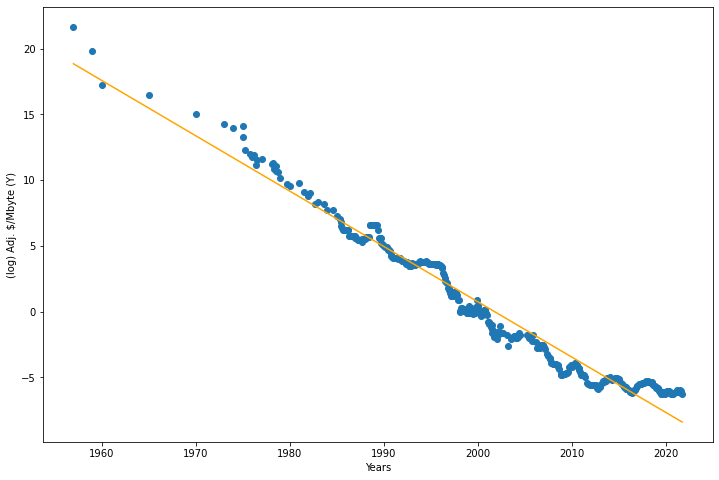

In [28]:
mem_x = np.array(memory_prices_df[['date (X)', 'Adj. $/Mbyte (Y)']]['date (X)'])
mem_y = np.log(memory_prices_df[['date (X)', 'Adj. $/Mbyte (Y)']]['Adj. $/Mbyte (Y)']).tolist()

mem_x = mem_x.reshape((-1, 1))
reg = LinearRegression().fit(mem_x, mem_y)
preds = reg.predict(mem_x)
r2 = r2_score(mem_y, preds)
plt.figure(figsize=(12, 8))
plt.plot(mem_x, preds, color='orange')
plt.scatter(mem_x, mem_y)
plt.xlabel('Years')
plt.ylabel('(log) Adj. $/Mbyte (Y)')
plt.savefig('mem_cost.png')
plt.show()

In [29]:
unobserved_labels = np.array([1944.00 + i for i in range(13)]).reshape((-1, 1))
recovered_estimates = np.exp(reg.predict(unobserved_labels))
recovered_estimates

array([3.67493558e+10, 2.41252517e+10, 1.58377680e+10, 1.03971928e+10,
       6.82555895e+09, 4.48084937e+09, 2.94159221e+09, 1.93109923e+09,
       1.26772984e+09, 8.32240480e+08, 5.46350014e+08, 3.58668372e+08,
       2.35458951e+08])

In [30]:
for i in range(len(unobserved_labels)):
    memory_prices_df = memory_prices_df.append({'date (X)': unobserved_labels[i][0], '$/Mbyte (Y)': recovered_estimates[i], 'Adj. $/Mbyte (Y)': cpi.inflate(recovered_estimates[i], int(unobserved_labels[i][0]), to=2001)}, ignore_index=True)

In [31]:
memory_prices_df = memory_prices_df.sort_values(by=['date (X)']).reset_index(drop=True)
memory_prices_df["Adj. $/Mbyte (Y)"] = memory_prices_df.apply(lambda x: cpi.inflate(x["$/Mbyte (Y)"], 2001), axis=1)

In [32]:
memory_prices_df_filtered = memory_prices_df[memory_prices_df['date (X)'] < 2004]
memory_prices_df_filtered

,date (X),$/Mbyte (Y),Date,,Ref:,Page,Company,Size,Cost,Speed,Memory Type,JDR Chip Prices,,,Adj. $/Mbyte (Y)
0,1944.00,3.674936e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.622797e+10
1,1945.00,2.412525e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.691259e+10
2,1946.00,1.583777e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.423241e+10
3,1947.00,1.039719e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.590812e+10
4,1948.00,6.825559e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.044337e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,2003.58,1.290000e-01,2003,Aug19,Pcmag,54,Crucial,524288,65.99,,512MB DIMM SDRAM @ $65.99,,,,1.973751e-01
249,2003.67,1.430000e-01,2003,Set16,Pcmag,64,Crucial,524288,72.99,,512MB DIMM SDRAM @ $72.99,,,,2.187957e-01
250,2003.75,1.480000e-01,2003,Oct1,Pcmag,54,Crucial,524288,75.99,,512MB DIMM SDRAM @ $75.99,,,,2.264458e-01
251,2003.83,1.600000e-01,2003,Nov25,Pcmag,82,Crucial,524288,81.99,,512MB DIMM PC-133 @ $81.99,,,,2.448063e-01


In [33]:
cpu_performance_df_filtered

,Year,Model,Price US$,MB,Performance,Quantity,Adj. Price US$
0,1944,Harvard Mark I,442686.0,NaN,0.0000001,1,4.454528e+06
1,1945,ENIAC,487000.0,NaN,0.0000182,1,4.791539e+06
2,1950,Whirlwind I,708909.0,NaN,0.0000710,1,5.209452e+06
3,1951,UNIVAC I,900000.0,0.001,0.00019,1,6.130385e+06
4,1952,EDVAC,415906.0,NaN,0.0000217,1,2.779508e+06
...,...,...,...,...,...,...,...
454,2001,Dell PW330-1.5,2850.0,256,"2,495",12,2.850000e+03
456,2001,SUN Blade 1000,10000.0,NaN,"4,189",13,1.000000e+04
458,2002,NEC Earth Simulator,350000000.0,NaN,"28,293,540",17,3.445525e+08
459,2002,ASCI Q,215000000.0,NaN,"10,951,320",17,2.116537e+08


In [34]:
# load fabrication and material dataset
fabrication_df = pd.read_csv('fabrication.csv')
mosfet_df = pd.read_csv('mosfet.csv')

In [35]:
memory_prices_df.head()

,date (X),$/Mbyte (Y),Date,,Ref:,Page,Company,Size,Cost,Speed,Memory Type,JDR Chip Prices,,,Adj. $/Mbyte (Y)
0,1944.0,3.674936e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.622797e+10
1,1945.0,2.412525e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.691259e+10
2,1946.0,1.583777e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.423241e+10
3,1947.0,1.039719e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.590812e+10
4,1948.0,6.825559e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.044337e+10


In [36]:
def find_transistor(date):
    dates = mosfet_df['invention'].tolist()
    closest = 0
    for d in dates:
        if d > date:
            continue
        if d > closest:
            closest = mosfet_df.iloc[mosfet_df.index[mosfet_df['invention'] == d].tolist()[0]]['dimension (mircons)']
    return closest

def find_memory(date):
    return memory_prices_df.iloc[(memory_prices_df['date (X)']-date).abs().argsort()[:]][(memory_prices_df['date (X)'] <= date)]['$/Mbyte (Y)'].iloc[0]

def find_fabrications(date):
    dates = fabrication_df[' invention'].tolist()
    return [1 if date > d else 0 for d in dates]

In [37]:
Q = cpu_performance_df_filtered['Quantity'].str.replace('est-', '').astype(float, errors='raise').tolist()

In [38]:
P = cpu_performance_df_filtered['Price US$'].tolist()

In [39]:
O = cpu_performance_df_filtered['Performance'].str.replace(',', '').astype(float, errors='raise').tolist() # measured in MIPS

In [40]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
M = np.array([find_memory(year) for year in cpu_performance_df_filtered['Year'].astype(float, errors='raise').tolist()])

In [42]:
F = np.array([find_fabrications(year) for year in cpu_performance_df_filtered['Year'].astype(float, errors='raise').tolist()]).T
F1, F2, F3, F4, F5, F6 = F

In [43]:
F1.shape

(334,)

In [44]:
X = np.zeros((334, 9))
X[:, 0] = Q
X[:, 1] = M
X[:, 2] = O
X[:, 3] = F1
X[:, 4] = F2
X[:, 5] = F3
X[:, 6] = F4
X[:, 7] = F5
X[:, 8] = F6

In [45]:
feature_names = ['Q', 'M', 'O', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6']

In [46]:
Y = P

In [47]:
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X)
poly_names = poly_features.get_feature_names(feature_names)

In [48]:
regr = LinearRegression()
regr.fit(X_poly, Y)
pred = regr.predict(X_poly)
coef_map = {}
for idx, coef in enumerate(regr.coef_):
    coef_map[f"beta{idx}"] = (poly_names[idx], coef)
coef_map
mean_squared_error(pred, Y), r2_score(pred, Y)

(36525036615744.33, 0.9224502918653121)

In [70]:
# Compute partial derivate for practicality score
zeta_betas = ["beta3", "beta12", "beta20", "beta27", "beta28", "beta29", "beta30", "beta31", "beta32", "beta33"]
zeta_coefs = [coef_map[beta][1] for beta in zeta_betas]
rho_betas = ["beta1", "beta10", "beta11", "beta12", "beta13", "beta14", "beta15", "beta16", "beta17", "beta18"]
rho_coefs = [coef_map[beta][1] for beta in rho_betas]

In [71]:
# X[:, 0] = Q
# X[:, 1] = M
# X[:, 2] = O
# X[:, 3] = F1
# X[:, 4] = F2
# X[:, 5] = F3
# X[:, 6] = F4
# X[:, 7] = F5
# X[:, 8] = F6
O_fac = np.zeros(334) + zeta_coefs[0]
Q_fac = X[:, 0] * zeta_coefs[1]
M_fac = X[:, 1] * zeta_coefs[2]
O2_fac = X[:, 2] * zeta_coefs[3]
F1_fac = X[:, 3] * zeta_coefs[4]
F2_fac = X[:, 4] * zeta_coefs[5]
F3_fac = X[:, 5] * zeta_coefs[6]
F4_fac = X[:, 6] * zeta_coefs[7]
F5_fac = X[:, 7] * zeta_coefs[8]
F6_fac = X[:, 8] * zeta_coefs[9]
zetas = O_fac + Q_fac + M_fac + O2_fac + F1_fac + F2_fac + F3_fac + F4_fac + F5_fac + F6_fac

In [72]:
# rho_betas = ["beta1", "beta10", "beta11", "beta12", "beta13", "beta14", "beta15", "beta16", "beta17", "beta18"]
Q_fac = np.zeros(334) + rho_coefs[0]
Q2_fac = X[:, 0] * rho_coefs[1]
M_fac = X[:, 1] * rho_coefs[2]
O_fac = X[:, 2] * rho_coefs[3]
F1_fac = X[:, 3] * rho_coefs[4]
F2_fac = X[:, 4] * rho_coefs[5]
F3_fac = X[:, 5] * rho_coefs[6]
F4_fac = X[:, 6] * rho_coefs[7]
F5_fac = X[:, 7] * rho_coefs[8]
F6_fac = X[:, 8] * rho_coefs[9]
rhos = Q_fac + Q2_fac + M_fac + O_fac + F1_fac + F2_fac + F3_fac + F4_fac + F5_fac + F6_fac

In [81]:
-rhos[:10], zetas[:10]

(array([1.47076468e+09, 9.65528983e+08, 1.17726960e+08, 7.72855054e+07,
        5.07364614e+07, 3.33075200e+07, 3.33075200e+07, 3.33075200e+07,
        2.18657521e+07, 2.18657521e+07]),
 array([4.13315026e+09, 2.71333437e+09, 3.30836892e+08, 2.17188115e+08,
        1.42579859e+08, 9.36009603e+07, 9.36009603e+07, 9.36009603e+07,
        6.14472470e+07, 6.14472470e+07]))

In [74]:
# compute decade computer counts
epoch1 = []
epoch2 = []
epoch3 = []
for year in cpu_performance_df_filtered['Year'].astype(float):
    if year <= 1970:
        epoch1.append(year)
    elif year <= 1985:
        epoch2.append(year)
    else:
        epoch3.append(year)
print(len(epoch1), len(epoch2), len(epoch3))
epoch1_df = cpu_performance_df_filtered.iloc[:len(epoch1)]
epoch2_df = cpu_performance_df_filtered.iloc[len(epoch1):len(epoch2)]
epoch3_df = cpu_performance_df_filtered.iloc[len(epoch2):]

60 170 104


In [75]:
epoch1_zetas, epoch1_rhos = zetas[:len(epoch1)], rhos[:len(epoch1)]
epoch2_zetas, epoch2_rhos = zetas[len(epoch1):len(epoch1)+len(epoch2)], rhos[len(epoch1):len(epoch1)+len(epoch2)]
epoch3_zetas, epoch3_rhos = zetas[len(epoch1)+len(epoch2):], rhos[len(epoch1)+len(epoch2):]

In [76]:
len(epoch1_zetas), len(epoch1_rhos)

(60, 60)

In [77]:
len(epoch2_zetas), len(epoch2_rhos)

(170, 170)

In [78]:
len(epoch3_zetas), len(epoch3_rhos)

(104, 104)

In [79]:
# reg = LinearRegression()
# inv_x = np.array(1/cpu_performance_df_filtered['Year'].astype(float)[3:]).reshape((331, -1))
# # zetas_f = np.,
# reg.fit(inv_x, np.array(zetas[3:]))
# preds = reg.predict(inv_x)
# inv_x
X = cpu_performance_df_filtered['Year'].astype(float)
theta = np.polyfit(np.log(X), np.log(zetas), 2)
y_line = theta[2] + theta[1] * pow(X, 1) + theta[0] * pow(X, 2)

In [80]:
X = np.array(X).reshape((334, -1))
log_zetas = np.nan_to_num(np.log(zetas))
reg = LinearRegression()
reg.fit(np.log(X), log_zetas)
preds = reg.predict(np.log(X))
r2_score(log_zetas, preds), reg.coef_[0]

(0.9498449694718789, -739.9865572957591)

In [60]:
pred_exp = np.exp(log_zetas)

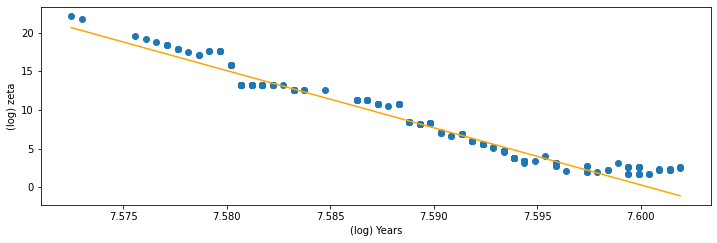

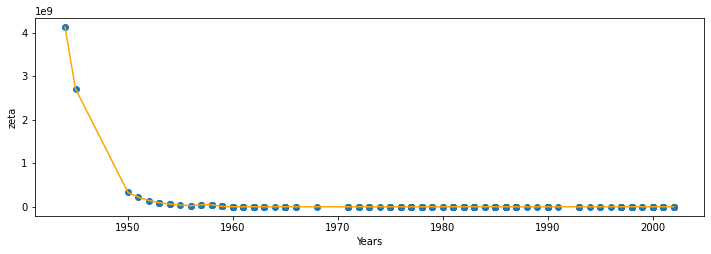

In [100]:
plt.figure(figsize=(12, 8))
# plt.scatter(np.log(epoch3_zetas), np.log(epoch3_rhos))
# plt.scatter(epoch2_zetas, epoch2_rhos)
# plt.scatter(epoch3_zetas, epoch3_rhos)
# plt.plot(X, y_line)
plt.subplot(2, 1, 1)
plt.plot(np.log(X), preds, color='orange')
plt.scatter(np.log(X), np.log(zetas))
plt.ylabel("(log) zeta")
plt.xlabel("(log) Years")
plt.show()
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 2)
plt.plot(X, pred_exp, color='orange')
plt.scatter(X, zetas)
plt.ylabel("zeta")
plt.xlabel("Years")
plt.show()

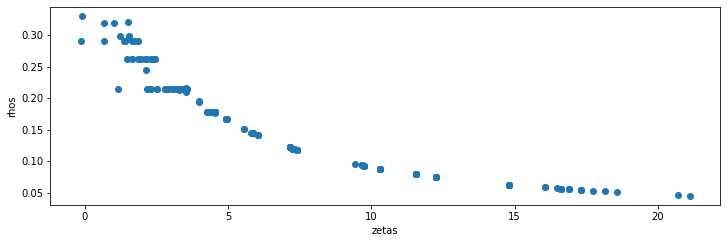

In [131]:
plt.figure(figsize=(12, 8))
# plt.scatter(np.log(epoch3_zetas), np.log(epoch3_rhos))
# plt.scatter(epoch2_zetas, epoch2_rhos)
# plt.scatter(epoch3_zetas, epoch3_rhos)
# plt.plot(X, y_line)
plt.subplot(2, 1, 1)
# plt.plot(np.log(X), preds, color='orange')
# plt.scatter(np.log(X), np.log(zetas))
# plt.ylabel("(log) zeta")
# plt.xlabel("(log) Years")
# plt.show()
# plt.figure(figsize=(12, 8))
# plt.subplot(2, 1, 2)
# plt.plot(X, pred_exp, color='orange')
plt.scatter(np.log(-rhos), 1/np.log(zetas))
# plt.scatter(np.log(-rhos[10:30]), 1/np.log(zetas[10:30]))
plt.ylabel("rhos")
plt.xlabel("zetas")
plt.show()

In [132]:
X.T[0].shape

(334,)

<IPython.core.display.Javascript object>


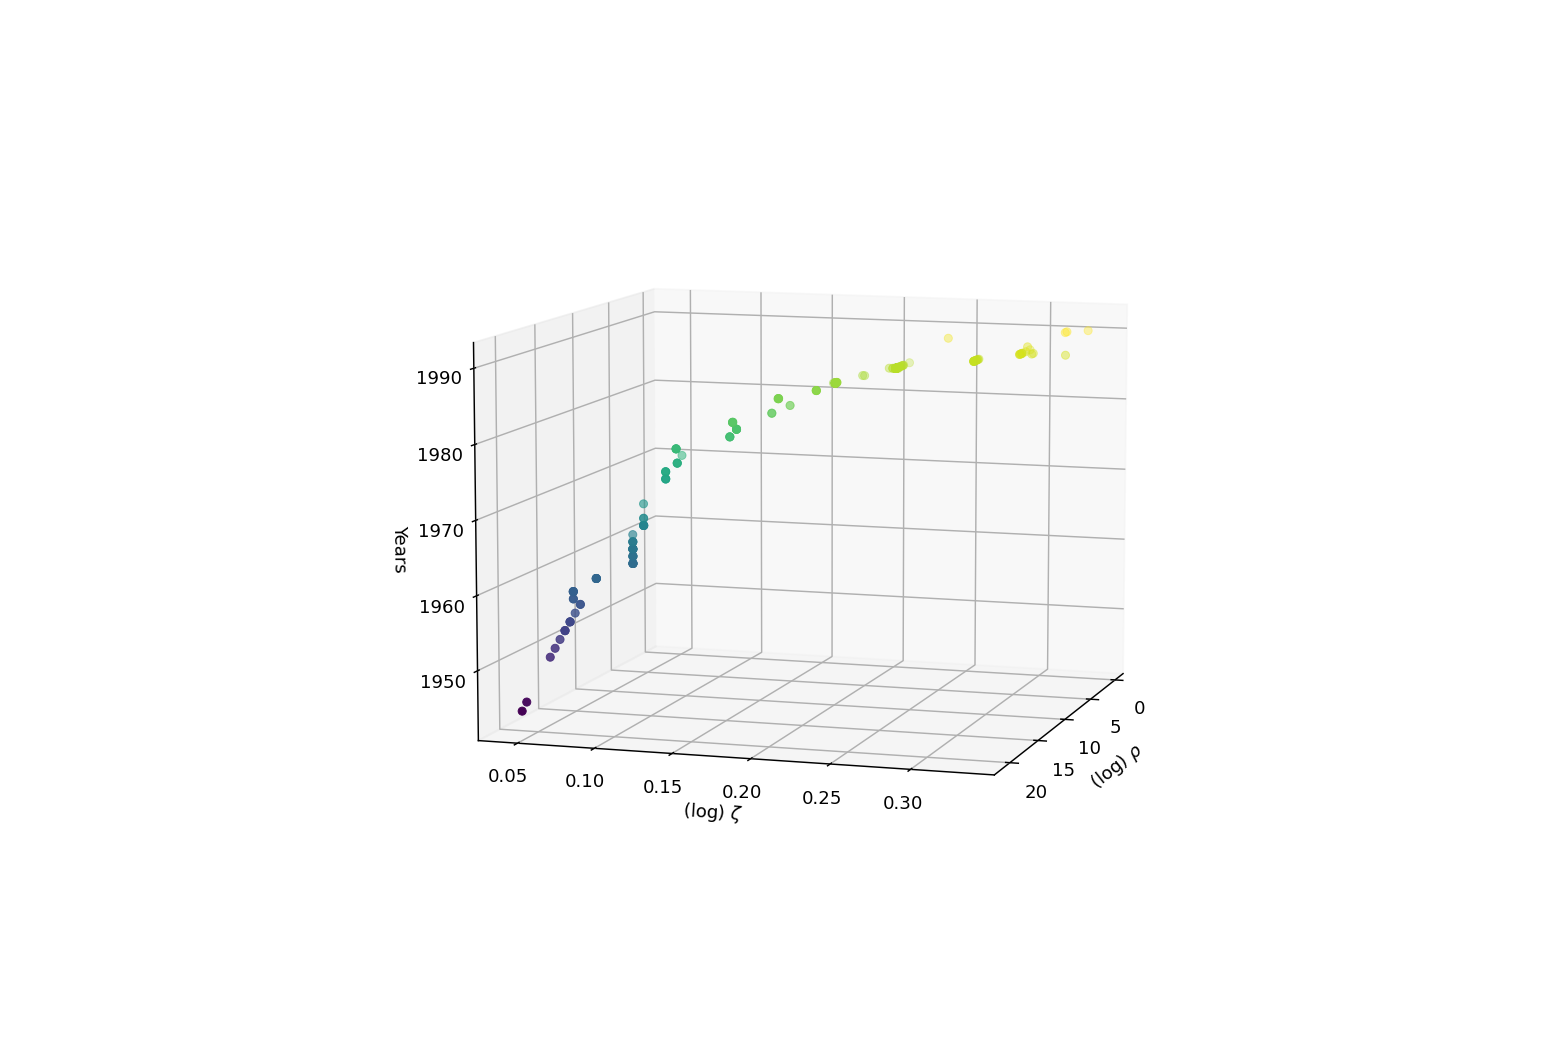

In [138]:
%matplotlib notebook
plt.figure(figsize=(12, 8))
ax = plt.axes(projection='3d')
ax.set_xlabel(r"(log) $\rho$")
ax.set_ylabel(r"(log) $\zeta$")
ax.set_zlabel("Years")
ax.scatter3D(np.log(-rhos), 1/np.log(zetas), X.T[0], c=X.T[0], cmap='viridis', linewidth=0.5)
# ax.view_init(60, 35)